In [1]:
# instalar o plotly
!pip install plotly==4.9

# Importar Bibliotecas 

In [2]:
import pandas as pd
import numpy as np
# Gráficos basicos do plot
import plotly.express as px

# Carregar Dataset Movielens

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


https://grouplens.org/datasets/movielens/


Este Exemplo: https://grouplens.org/datasets/movielens/10m/


In [4]:
# Carregar um arquivo csv para um dataframe
# Documentação do comando: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html
# Carregando CSV dos filmes
df_filmes = pd.read_csv('/content/drive/My Drive/Colab Notebooks/DM1/movies/movies.dat', sep='::', names=['id_filme', 'nome', 'categoria'])
df_filmes.head(3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: ParserWarning:

Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.



,id_filme,nome,categoria
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [5]:
df_ava = pd.read_csv('/content/drive/My Drive/Colab Notebooks/DM1/movies/ratings.dat', sep= '::', names=['id_usuario','id_filme','avaliacao','timestamp'] )
df_ava.head(3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ParserWarning:

Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.



,id_usuario,id_filme,avaliacao,timestamp
0,1,122,5.0,838985046
1,1,185,5.0,838983525
2,1,231,5.0,838983392


# Ajustando as datas

Unix Timestamp -> Datetime

In [6]:
df_ava['data'] = pd.to_datetime(df_ava['timestamp'], unit='s').dt.date
df_ava.head(3)

,id_usuario,id_filme,avaliacao,timestamp,data
0,1,122,5.0,838985046,1996-08-02
1,1,185,5.0,838983525,1996-08-02
2,1,231,5.0,838983392,1996-08-02


## Filtros e condições inicíais

### Remover usúarios que votaram menos de X vezes

In [7]:
# Verificando quantas avaliações foram feitas por cada usuário:
# .value_counts() -> dica do Henrique Saboya (valeu!), mais eficiente que realizar um groupby
df_qtd_ava = df_ava.id_usuario.value_counts()
df_qtd_ava.head(3)

59269    7359
67385    7047
14463    5169
Name: id_usuario, dtype: int64

### Sumarização

In [8]:
# Que mais votaram
df_qtd_ava.nlargest(3)

59269    7359
67385    7047
14463    5169
Name: id_usuario, dtype: int64

In [9]:
# Que menos votaram
df_qtd_ava.nsmallest(3)

2773     20
57408    20
14391    20
Name: id_usuario, dtype: int64

In [10]:
# Media e mediana
print( 'media:', df_qtd_ava.mean() )
print( 'mediana:', df_qtd_ava.median() )

media: 143.10732991785684
mediana: 69.0


### BoxPlot

Para conhecer os quartis da quantidade de avaliações realizadas por usuário

In [11]:
# Quero todas as métricas de uma vez:
df_qtd_ava.describe()

count    69878.00000
mean       143.10733
std        216.71258
min         20.00000
25%         35.00000
50%         69.00000
75%        156.00000
max       7359.00000
Name: id_usuario, dtype: float64

In [12]:
import plotly.express as px
fig = px.histogram(df_qtd_ava, 
                   marginal="box") # or violin, rug)
fig.show()

In [13]:
# Se eu for cortar, quanto perco do meu dataset em cada valor de corte?
print( 'Valor para corte superior: ', df_qtd_ava.quantile(0.98) ) # 98% <

Valor para corte superior:  806.0


In [14]:
# Aplicando o filtro
df_qtd_ava_filtrado = df_qtd_ava[ ((df_qtd_ava <= 806)) ]
print( df_qtd_ava.shape )
print( df_qtd_ava_filtrado.shape )

(69878,)
(68487,)


In [15]:
import plotly.express as px
fig = px.histogram(df_qtd_ava_filtrado, 
                   marginal="box") # or violin, rug)
fig.show()

In [16]:
df_qtd_ava_filtrado.describe()

count    68487.000000
mean       121.277396
std        135.995655
min         20.000000
25%         35.000000
50%         67.000000
75%        147.000000
max        806.000000
Name: id_usuario, dtype: float64

In [17]:
# Filtrar os usuários do dataset original
print(df_qtd_ava_filtrado.head(3))

20312    806
64581    806
64453    806
Name: id_usuario, dtype: int64


In [18]:
lista_usuarios = list( df_qtd_ava_filtrado.index )
df_ava_fil = df_ava[ df_ava.id_usuario.isin( lista_usuarios ) ]


In [19]:
# Comparar a redução de linhas
print( df_ava.shape )
print( df_ava_fil.shape )

(10000054, 5)
(8305925, 5)


# One hot Encoding das categorias utilizando CountVectorizer

No notebook AD_SR_Filmes.ipynb esse passos foram utilizados para criar colunas com as categorias dos filmes assistidos apra dizer qual o genero mais popular entre os usuários. 

## Preparando dataframe de filmes com a quantidade de votações

Iremos remover os filmes que tiveram menos de N avaliações do dataframe de filmes no momento da sugestão

In [20]:
# Relembrando
df_ava_fil.head(2)

,id_usuario,id_filme,avaliacao,timestamp,data
0,1,122,5.0,838985046,1996-08-02
1,1,185,5.0,838983525,1996-08-02


In [21]:
# Verificar a quantidade de filmes avaliados no dataset de avaliações já filtrado sem os outliers (usuários que avaliaram MUITOS filmes)
df_mais_avaliados = df_ava_fil.id_filme.value_counts().rename('qtd_avaliada')
print( df_mais_avaliados.head(2) )
print( df_mais_avaliados.tail(2) )

296    33557
356    33137
Name: qtd_avaliada, dtype: int64
50619    1
26059    1
Name: qtd_avaliada, dtype: int64


In [22]:
# Mergear a quantidade de vezes que foi avaliado no dataframe de filmes
df_filmes_qtd = df_filmes.merge( df_mais_avaliados, how='left', left_on = 'id_filme', right_index = True )
df_filmes_qtd.fillna(0, inplace = True)
df_filmes_qtd.head(2)

,id_filme,nome,categoria,qtd_avaliada
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,25198.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,11048.0


In [23]:
# Alterando o tipo de dados de uma coluna
df_filmes_qtd.qtd_avaliada = df_filmes_qtd.qtd_avaliada.astype(int)
# Reordenando as colunas
df_filmes_qtd = df_filmes_qtd[['id_filme', 'qtd_avaliada', 'nome', 'categoria']]
df_filmes_qtd.head(2)

,id_filme,qtd_avaliada,nome,categoria
0,1,25198,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,11048,Jumanji (1995),Adventure|Children|Fantasy


## Vetorizando as categorias

Os gêneros estão estão em uma tabela no formato de texto, precisamos contabilizar no dataframe de avaliações.


In [24]:
# Relembrando
df_filmes_qtd.head(2)

,id_filme,qtd_avaliada,nome,categoria
0,1,25198,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,11048,Jumanji (1995),Adventure|Children|Fantasy


Expandindo a string categoria em colunas com separadas por '|'

In [25]:
df_cat_expandido = df_filmes_qtd.categoria.str.split('|', expand=True)
df_cat_expandido.head(3)

,0,1,2,3,4,5,6,7
0,Adventure,Animation,Children,Comedy,Fantasy,None,None,None
1,Adventure,Children,Fantasy,None,None,None,None,None
2,Comedy,Romance,None,None,None,None,None,None


In [26]:
# Lista com todos os generos que aparecem no dataset
conjunto_cat = set( df_cat_expandido[0].unique() )
for i in range(1, 8):
    conjunto_cat.union( set(df_cat_expandido[i].unique()) )

conjunto_cat

{'(no genres listed)',
 'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western'}

Remover IMAX e (no genres listed) do vocabulário

In [27]:
conjunto_cat.remove( '(no genres listed)' )
conjunto_cat.remove( 'IMAX' )
print(conjunto_cat)

{'Animation', 'Musical', 'Documentary', 'Western', 'Mystery', 'Horror', 'Adventure', 'Sci-Fi', 'Thriller', 'Fantasy', 'Romance', 'Crime', 'Drama', 'War', 'Children', 'Comedy', 'Action', 'Film-Noir'}


### Gerando o próprio dicionario para o vocabulario do CountVectorizer

Iremos utilizar o CountVectorizer do sklearn para criar um vocabulário (dicionário) para cada categoria, e depois disso utilizar esse vocabulário para criar um vetor com 1 na categoria do filme e 0 nas outras (one-hot-encoding)

In [28]:
voc_dict = {}

i = 0
for gen in conjunto_cat:
    voc_dict[ gen.lower() ] = i
    i = i + 1

voc_dict

{'action': 16,
 'adventure': 6,
 'animation': 0,
 'children': 14,
 'comedy': 15,
 'crime': 11,
 'documentary': 2,
 'drama': 12,
 'fantasy': 9,
 'film-noir': 17,
 'horror': 5,
 'musical': 1,
 'mystery': 4,
 'romance': 10,
 'sci-fi': 7,
 'thriller': 8,
 'war': 13,
 'western': 3}

**Usar o CountVectorizer para vetorizar o campo categoria do dataframe de filmes**

Documentação: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

Tutorial: https://kavita-ganesan.com/how-to-use-countvectorizer/#Example-of-How-CountVectorizer-Works



In [29]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer( analyzer = 'word', vocabulary = voc_dict, ngram_range=(1,2), token_pattern = '[a-zA-Z0-9$&+,:;=?@#<>.^*()%!-]+' )
# Treinar o vocabulário com o conjunto de categorias
vectorizer.fit( conjunto_cat )
# Verificar o vocabulario aprendido pelo objeto 'vectorizer'
vectorizer.vocabulary_

{'action': 16,
 'adventure': 6,
 'animation': 0,
 'children': 14,
 'comedy': 15,
 'crime': 11,
 'documentary': 2,
 'drama': 12,
 'fantasy': 9,
 'film-noir': 17,
 'horror': 5,
 'musical': 1,
 'mystery': 4,
 'romance': 10,
 'sci-fi': 7,
 'thriller': 8,
 'war': 13,
 'western': 3}

O campo categoria de cada linha será convertido em one-hot pelo **vectorizer**

Exemplo:

[ 0,0 ,0 ,1 ,0 ,1 ,0 ,0 ,0 ,1 ,0 ,1 ,0 ,0 ,0 ,0, 1, 0, 0 ]  <- 18 posições
[ 0,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,1 ,0 ,0 ,0 ,0, 0, 0, 0 ]  <- 18 posições

In [30]:
# Matriz esparça resultante
matriz_cat = vectorizer.transform( df_filmes_qtd.categoria )
matriz_cat

<10681x18 sparse matrix of type '<class 'numpy.int64'>'
	with 21534 stored elements in Compressed Sparse Row format>

In [31]:
# Verificando a matriz em sua forma densa
matriz_cat.todense()

matrix([[1, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 0, 0],
        ...,
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 0, 0]])

Qual a sequência de nomes de cada coluna da matriz densa?

Podemos descobrir usando o comando get_feature_names: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer.get_feature_names

In [32]:
# Nome das colunas
vectorizer.get_feature_names()

['animation',
 'musical',
 'documentary',
 'western',
 'mystery',
 'horror',
 'adventure',
 'sci-fi',
 'thriller',
 'fantasy',
 'romance',
 'crime',
 'drama',
 'war',
 'children',
 'comedy',
 'action',
 'film-noir']

### Criando um dataframe a partir da matriz vetorizada e o nome das features

In [33]:
df_categoria_onehot = pd.DataFrame( data =matriz_cat.todense(), columns = vectorizer.get_feature_names() )
df_categoria_onehot.head(3)

,animation,musical,documentary,western,mystery,horror,adventure,sci-fi,thriller,fantasy,romance,crime,drama,war,children,comedy,action,film-noir
0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0
1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0


Agora vamos mergear essa coluna com o dataframe de filmes e conferir se o merge foi realizado corretamente.

Vamos utilizar o index para realizar este merge.

In [34]:
df_filmes_cat_onehot =  pd.merge( df_filmes_qtd, df_categoria_onehot, how='left', left_index=True, right_index=True )
df_filmes_cat_onehot.head(3)

,id_filme,qtd_avaliada,nome,categoria,animation,musical,documentary,western,mystery,horror,adventure,sci-fi,thriller,fantasy,romance,crime,drama,war,children,comedy,action,film-noir
0,1,25198,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0
1,2,11048,Jumanji (1995),Adventure|Children|Fantasy,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0
2,3,7177,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0


# Criando dataframe de avaliações com o one-hot de categorias mergeado

In [35]:
df_ava_filme_cat_onehot = pd.merge( df_ava, df_filmes_cat_onehot, how='left', left_on='id_filme', right_on='id_filme' )
df_ava_filme_cat_onehot.head(3)

,id_usuario,id_filme,avaliacao,timestamp,data,qtd_avaliada,nome,categoria,animation,musical,documentary,western,mystery,horror,adventure,sci-fi,thriller,fantasy,romance,crime,drama,war,children,comedy,action,film-noir
0,1,122,5.0,838985046,1996-08-02,2069,Boomerang (1992),Comedy|Romance,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1,1,185,5.0,838983525,1996-08-02,14043,"Net, The (1995)",Action|Crime|Thriller,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0
2,1,231,5.0,838983392,1996-08-02,16819,Dumb & Dumber (1994),Comedy,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


# Sistema de Recomendação

Um pouco sobre tipos de sistemas de recomendação: https://www.bluepiit.com/blog/classifying-recommender-systems/#:~:text=There%20are%20majorly%20six%20types,system%20and%20Hybrid%20recommender%20system.


https://medium.com/@jwu2/types-of-recommender-systems-9cc216294802

In [36]:
# relembrando
df_ava_filme_cat_onehot.head(3)

,id_usuario,id_filme,avaliacao,timestamp,data,qtd_avaliada,nome,categoria,animation,musical,documentary,western,mystery,horror,adventure,sci-fi,thriller,fantasy,romance,crime,drama,war,children,comedy,action,film-noir
0,1,122,5.0,838985046,1996-08-02,2069,Boomerang (1992),Comedy|Romance,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1,1,185,5.0,838983525,1996-08-02,14043,"Net, The (1995)",Action|Crime|Thriller,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0
2,1,231,5.0,838983392,1996-08-02,16819,Dumb & Dumber (1994),Comedy,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [37]:
df_ava_filme_cat_onehot.groupby('id_usuario').sum()

,id_filme,avaliacao,timestamp,qtd_avaliada,animation,musical,documentary,western,mystery,horror,adventure,sci-fi,thriller,fantasy,romance,crime,drama,war,children,comedy,action,film-noir
id_usuario,,,,,,,,,,,,,,,,,,,,,,
1,9057,110.0,18457649035,320120,4,3,0,0,0,0,6,5,5,2,5,2,6,2,7,11,10,0
2,15711,64.0,17364906892,294097,0,1,0,1,1,1,10,6,7,1,4,1,7,3,1,4,14,0
3,179578,130.0,37626818010,195662,2,1,0,3,4,0,6,0,6,3,12,3,20,6,2,11,7,1
4,13501,153.0,32087840561,662204,3,3,0,3,0,1,13,8,11,5,8,5,14,3,5,19,17,0
5,56883,335.0,74638384961,691286,1,4,0,0,4,6,8,8,14,4,26,11,64,6,4,29,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71563,353205,148.0,49971748102,370604,1,1,0,0,7,4,10,7,22,3,7,11,20,6,1,9,25,0
71564,293244,313.0,116712265805,810116,3,1,1,5,5,3,25,18,23,10,17,19,45,3,3,53,37,0
71565,279666,564.0,141275137920,989235,8,5,1,6,9,10,31,34,26,11,17,18,73,17,8,45,36,3


In [38]:
df_ava_filme_cat_onehot.groupby('id_usuario').mean()

,id_filme,avaliacao,timestamp,qtd_avaliada,animation,musical,documentary,western,mystery,horror,adventure,sci-fi,thriller,fantasy,romance,crime,drama,war,children,comedy,action,film-noir
id_usuario,,,,,,,,,,,,,,,,,,,,,,
1,411.681818,5.000000,8.389840e+08,14550.909091,0.181818,0.136364,0.000000,0.000000,0.000000,0.000000,0.272727,0.227273,0.227273,0.090909,0.227273,0.090909,0.272727,0.090909,0.318182,0.500000,0.454545,0.000000
2,785.550000,3.200000,8.682453e+08,14704.850000,0.000000,0.050000,0.000000,0.050000,0.050000,0.050000,0.500000,0.300000,0.350000,0.050000,0.200000,0.050000,0.350000,0.150000,0.050000,0.200000,0.700000,0.000000
3,5441.757576,3.939394,1.140207e+09,5929.151515,0.060606,0.030303,0.000000,0.090909,0.121212,0.000000,0.181818,0.000000,0.181818,0.090909,0.363636,0.090909,0.606061,0.181818,0.060606,0.333333,0.212121,0.030303
4,355.289474,4.026316,8.444169e+08,17426.421053,0.078947,0.078947,0.000000,0.078947,0.000000,0.026316,0.342105,0.210526,0.289474,0.131579,0.210526,0.131579,0.368421,0.078947,0.131579,0.500000,0.447368,0.000000
5,653.827586,3.850575,8.579125e+08,7945.816092,0.011494,0.045977,0.000000,0.000000,0.045977,0.068966,0.091954,0.091954,0.160920,0.045977,0.298851,0.126437,0.735632,0.068966,0.045977,0.333333,0.057471,0.011494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71563,8214.069767,3.441860,1.162134e+09,8618.697674,0.023256,0.023256,0.000000,0.000000,0.162791,0.093023,0.232558,0.162791,0.511628,0.069767,0.162791,0.255814,0.465116,0.139535,0.023256,0.209302,0.581395,0.000000
71564,2792.800000,2.980952,1.111545e+09,7715.390476,0.028571,0.009524,0.009524,0.047619,0.047619,0.028571,0.238095,0.171429,0.219048,0.095238,0.161905,0.180952,0.428571,0.028571,0.028571,0.504762,0.352381,0.000000
71565,1928.731034,3.889655,9.743113e+08,6822.310345,0.055172,0.034483,0.006897,0.041379,0.062069,0.068966,0.213793,0.234483,0.179310,0.075862,0.117241,0.124138,0.503448,0.117241,0.055172,0.310345,0.248276,0.020690


In [39]:
df_ava_filme_cat_onehot.head(3)

,id_usuario,id_filme,avaliacao,timestamp,data,qtd_avaliada,nome,categoria,animation,musical,documentary,western,mystery,horror,adventure,sci-fi,thriller,fantasy,romance,crime,drama,war,children,comedy,action,film-noir
0,1,122,5.0,838985046,1996-08-02,2069,Boomerang (1992),Comedy|Romance,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1,1,185,5.0,838983525,1996-08-02,14043,"Net, The (1995)",Action|Crime|Thriller,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0
2,1,231,5.0,838983392,1996-08-02,16819,Dumb & Dumber (1994),Comedy,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [40]:
df_ava_filme_cat_onehot.iloc[:,10: ] = df_ava_filme_cat_onehot.iloc[:,10: ].multiply( df_ava_filme_cat_onehot.avaliacao, axis='index' )
df_ava_filme_cat_onehot.tail(8)

,id_usuario,id_filme,avaliacao,timestamp,data,qtd_avaliada,nome,categoria,animation,musical,documentary,western,mystery,horror,adventure,sci-fi,thriller,fantasy,romance,crime,drama,war,children,comedy,action,film-noir
10000046,71567,1986,1.0,912580553,1998-12-02,358,Halloween 5: The Revenge of Michael Myers (1989),Horror,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10000047,71567,2012,3.0,912580722,1998-12-02,9413,Back to the Future Part III (1990),Comedy|Sci-Fi|Western,0,0,0.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
10000048,71567,2028,5.0,912580344,1998-12-02,17714,Saving Private Ryan (1998),Action|Drama|War,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,5.0,0.0
10000049,71567,2107,1.0,912580553,1998-12-02,902,Halloween H20: 20 Years Later (1998),Horror|Thriller,0,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10000050,71567,2126,2.0,912649143,1998-12-03,2099,Snake Eyes (1998),Action|Crime|Mystery|Thriller,0,0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0
10000051,71567,2294,5.0,912577968,1998-12-02,4244,Antz (1998),Adventure|Animation|Children|Comedy|Fantasy,1,0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0
10000052,71567,2338,2.0,912578016,1998-12-02,1704,I Still Know What You Did Last Summer (1998),Horror|Mystery|Thriller,0,0,0.0,0.0,2.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10000053,71567,2384,2.0,912578173,1998-12-02,2296,Babe: Pig in the City (1998),Children|Comedy,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0


In [43]:
df_rec = df_ava_filme_cat_onehot.groupby(by='id_usuario').mean()

In [44]:
df_rec.iloc[:, 4:].describe()

,animation,musical,documentary,western,mystery,horror,adventure,sci-fi,thriller,fantasy,romance,crime,drama,war,children,comedy,action,film-noir
count,69878.000000,69878.000000,69878.000000,69878.000000,69878.000000,69878.000000,69878.000000,69878.000000,69878.000000,69878.000000,69878.000000,69878.000000,69878.000000,69878.000000,69878.000000,69878.000000,69878.000000,69878.000000
mean,0.056625,0.049683,0.028943,0.079577,0.220499,0.224611,0.839295,0.542432,0.989249,0.365229,0.723669,0.575268,1.614012,0.242452,0.306333,1.369714,1.075810,0.046706
std,0.056383,0.048382,0.068851,0.101512,0.170377,0.252380,0.417796,0.393212,0.444943,0.230108,0.377067,0.302069,0.569685,0.182462,0.285360,0.492987,0.558159,0.109691
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.021505,0.020833,0.000000,0.000000,0.115385,0.090909,0.539523,0.293103,0.681159,0.213333,0.474576,0.371706,1.222222,0.132530,0.129630,1.049400,0.663467,0.000000
50%,0.045455,0.040816,0.000000,0.057143,0.194728,0.176000,0.785714,0.470134,0.955224,0.327623,0.666667,0.539861,1.560282,0.208333,0.243243,1.318182,1.017123,0.000000
75%,0.076923,0.066667,0.033333,0.117647,0.292683,0.285714,1.083333,0.687500,1.259615,0.473446,0.903599,0.738095,1.953846,0.315955,0.400990,1.620381,1.405926,0.059211
max,1.000000,1.000000,2.950000,3.500000,3.703704,4.320000,3.860000,5.000000,4.130435,3.111111,4.160000,3.709677,5.000000,3.469136,4.523810,4.442478,4.580645,3.318182


In [45]:
import plotly.express as px

fig = px.box(df_rec.iloc[:50000, 4:])
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [47]:
df = df_rec.iloc[:, 4:]
df.head()

,animation,musical,documentary,western,mystery,horror,adventure,sci-fi,thriller,fantasy,romance,crime,drama,war,children,comedy,action,film-noir
id_usuario,,,,,,,,,,,,,,,,,,
1,0.181818,0.136364,0.0,0.000000,0.000000,0.000000,1.363636,1.136364,1.136364,0.454545,1.136364,0.454545,1.363636,0.454545,1.590909,2.500000,2.272727,0.000000
2,0.000000,0.050000,0.0,0.250000,0.100000,0.150000,1.700000,1.050000,1.000000,0.150000,0.550000,0.100000,1.150000,0.550000,0.150000,0.600000,2.300000,0.000000
3,0.060606,0.030303,0.0,0.333333,0.545455,0.000000,0.666667,0.000000,0.742424,0.378788,1.530303,0.363636,2.530303,0.742424,0.242424,1.212121,0.818182,0.121212
4,0.078947,0.078947,0.0,0.342105,0.000000,0.078947,1.447368,0.894737,1.131579,0.605263,0.789474,0.552632,1.684211,0.394737,0.657895,1.842105,1.763158,0.000000
5,0.011494,0.045977,0.0,0.000000,0.195402,0.298851,0.275862,0.310345,0.643678,0.172414,1.126437,0.540230,2.942529,0.275862,0.149425,1.195402,0.103448,0.057471


In [48]:
from sklearn.cluster import KMeans

n_kmax = 15
lista_inertias = []
for i in range(1, n_kmax):
    km = KMeans(  n_clusters=i , init='random', n_init=5, max_iter=150, random_state=0 )
    km.fit( df )
    lista_inertias.append(  km.inertia_  )

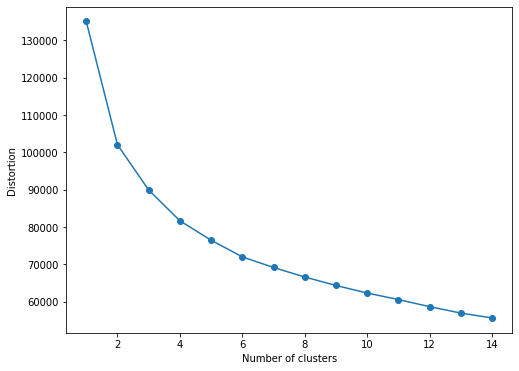

In [49]:
import matplotlib.pyplot as plt

# plot
plt.figure( figsize=(8,6) )
plt.plot(range(1, n_kmax), lista_inertias, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [50]:
N_cluster = 4

km = KMeans( n_clusters= N_cluster, init='random', max_iter=400, random_state=0, n_init=20 )
km.fit( df )

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=400, n_clusters=4,
       n_init=20, n_jobs=None, precompute_distances='auto', random_state=0,
       tol=0.0001, verbose=0)

In [51]:
y_km = km.predict( df )
y_km

array([0, 0, 2, ..., 3, 1, 0], dtype=int32)

In [52]:
df_rec.shape

(69878, 22)

In [53]:
len(y_km)

69878

In [54]:
userid = df.index
df_cluster =  pd.Series( data = y_km, name='cluster', index=userid )
df_cluster.head()

id_usuario
1    0
2    0
3    2
4    0
5    2
Name: cluster, dtype: int32

In [55]:
#relebrando
df_rec.head(3)

,id_filme,avaliacao,timestamp,qtd_avaliada,animation,musical,documentary,western,mystery,horror,adventure,sci-fi,thriller,fantasy,romance,crime,drama,war,children,comedy,action,film-noir
id_usuario,,,,,,,,,,,,,,,,,,,,,,
1,411.681818,5.000000,8.389840e+08,14550.909091,0.181818,0.136364,0.0,0.000000,0.000000,0.00,1.363636,1.136364,1.136364,0.454545,1.136364,0.454545,1.363636,0.454545,1.590909,2.500000,2.272727,0.000000
2,785.550000,3.200000,8.682453e+08,14704.850000,0.000000,0.050000,0.0,0.250000,0.100000,0.15,1.700000,1.050000,1.000000,0.150000,0.550000,0.100000,1.150000,0.550000,0.150000,0.600000,2.300000,0.000000
3,5441.757576,3.939394,1.140207e+09,5929.151515,0.060606,0.030303,0.0,0.333333,0.545455,0.00,0.666667,0.000000,0.742424,0.378788,1.530303,0.363636,2.530303,0.742424,0.242424,1.212121,0.818182,0.121212


In [56]:
df_rec_cluster = df_rec.merge( df_cluster, how='left', left_index=True, right_index=True  )
df_rec_cluster.head()

,id_filme,avaliacao,timestamp,qtd_avaliada,animation,musical,documentary,western,mystery,horror,adventure,sci-fi,thriller,fantasy,romance,crime,drama,war,children,comedy,action,film-noir,cluster
id_usuario,,,,,,,,,,,,,,,,,,,,,,,
1,411.681818,5.000000,8.389840e+08,14550.909091,0.181818,0.136364,0.0,0.000000,0.000000,0.000000,1.363636,1.136364,1.136364,0.454545,1.136364,0.454545,1.363636,0.454545,1.590909,2.500000,2.272727,0.000000,0
2,785.550000,3.200000,8.682453e+08,14704.850000,0.000000,0.050000,0.0,0.250000,0.100000,0.150000,1.700000,1.050000,1.000000,0.150000,0.550000,0.100000,1.150000,0.550000,0.150000,0.600000,2.300000,0.000000,0
3,5441.757576,3.939394,1.140207e+09,5929.151515,0.060606,0.030303,0.0,0.333333,0.545455,0.000000,0.666667,0.000000,0.742424,0.378788,1.530303,0.363636,2.530303,0.742424,0.242424,1.212121,0.818182,0.121212,2
4,355.289474,4.026316,8.444169e+08,17426.421053,0.078947,0.078947,0.0,0.342105,0.000000,0.078947,1.447368,0.894737,1.131579,0.605263,0.789474,0.552632,1.684211,0.394737,0.657895,1.842105,1.763158,0.000000,0
5,653.827586,3.850575,8.579125e+08,7945.816092,0.011494,0.045977,0.0,0.000000,0.195402,0.298851,0.275862,0.310345,0.643678,0.172414,1.126437,0.540230,2.942529,0.275862,0.149425,1.195402,0.103448,0.057471,2
